## `statemodify` Quickstarter Notebook #2 : Using the EVA Modification Function in the Gunnison River Basin

This notebook demonstrates the reservoir evaporation modification function using the Gunnison River Basin as an example. Reservoir evaporation is a pressing concern in the CRB. Lake Powell loses 0.86 million acre/ft per year to evaporation, which is over 6% of the flow into the Colorado River and nearly the allocation to the state of Utah. With warming temperatures driving aridification in the region, evaporation will play an increasingly important role in shortages to users.

### Step 1: Run a Historical Simulation in StateMod for the Gunnison Subbasin

To explore the importance of evaporation, we first we run baseline simulation as we did in the first notebook, but this time, using the dataset for the Gunnison.

In [1]:
import argparse
import logging
import os
import pickle
from string import Template
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statemodify as stm

In [3]:
# statemod directory
statemod_dir = "/usr/src/statemodify/statemod_gunnison_sjd"

# root directory of statemod data for the target basin
root_dir = os.path.join(statemod_dir, "src", "main", "fortran")

# home directory of notebook instance
home_dir = os.path.dirname(os.getcwd())

# path to the statemod executable
statemod_exe = os.path.join(root_dir, "statemod-17.0.3-gfortran-lin-64bit-o3")

# data directory and root name for the target basin
data_dir = os.path.join(
    home_dir,
    "data",
    "gm2015_StateMod_modified",
    "gm2015_StateMod_modified",
    "StateMod"
)

# directory to the target basin input files with root name for the basin
basin_path = os.path.join(data_dir, "gm2015B")

# scenarios output directory
scenarios_dir = os.path.join(data_dir, "scenarios")

# path to eva template file
eva_template_file = os.path.join(
    home_dir,
    "data",
    "gm2015B_template_eva.rsp"
)

In [4]:
# run statemod
subprocess.call([statemod_exe, basin_path, "-simulate"])

 Startup log file for messages to this point: /home/8f04c5969ed54204a64388872dd1b557/data/gm2015_StateMod_modified/gm2015_StateMod_modified/StateMod/gm2015B.rsp                                                                                                                                              
   Closing startup log file: statem.log
   Opening dataset log file: /home/8f04c5969ed54204a64388872dd1b557/data/gm2015_StateMod_modified/gm2015_StateMod_modified/StateMod/gm2015B.log                                                                                                                                              
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version:     17.0.3          
        Last revision date: 2021/09/12

________________________________________________________________________
  
  Subroutine Execut
  Subroutine Datinp



0

In this notebook, rather than acquiring user shortages which are found in the .xdd output file, we can track reservoir storage which is found in the `gm2015B.xre` output file. Thus, in `statemodify`, we create a method that will allow us to extract output from the `gm2015B.xre` file and save it as a .csv file. Here we extract the shortages for Blue Mesa, one of the most important upstream reservoirs in the Gunnison that is responsible for supplying emergency water to Lake Powell.

In [5]:
# create a directory to store the historical reservoir levels at Blue Mesa  
output_dir = os.path.join(data_dir, "historic_reservoir_levels")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# path the the xre file
xre_file = os.path.join(data_dir, "gm2015B.xre")

# structure ID for reservoir of interest
structure_ID = '6203532'  

# name of the reservoir
structure_name = 'Blue_Mesa' 

# extract the target info into a Pandas data frame
df = stm.extract_xre_data(structure_name=structure_name,
                          structure_id=structure_ID,
                          input_file=xre_file,
                          basin_name=None,
                          output_directory=output_dir,
                          write_csv=True,
                          write_parquet=None
)

We can then create an annual average from our extracted monthly reservoir storage.

In [6]:
output_xre_file = os.path.join(output_dir, "Blue_Mesa_xre_data.csv")

# read output data into a data frame
df = pd.read_csv(
    output_xre_file, 
    usecols=['Year','Init. Storage'],
    index_col=False) 

# calculate the annual average
df = df.groupby('Year').mean().reset_index()

df


,Year,Init. Storage
0,1908,441516.500000
1,1909,409705.807692
2,1910,378741.903846
3,1911,374242.865385
4,1912,402187.230769
...,...,...
101,2009,384270.711538
102,2010,380057.192308
103,2011,346074.019231
104,2012,290796.692308


Finally, we can plot this annual average over time. We see swings in the storage that correspond well with the earliest part of the streamflow record that was relatively wet along with dry periods (large dips around the 1930s dustbowl and 1950s drought and the severe early 2002 drought). 

Text(0, 0.5, 'Reservoir Storage (AF)')

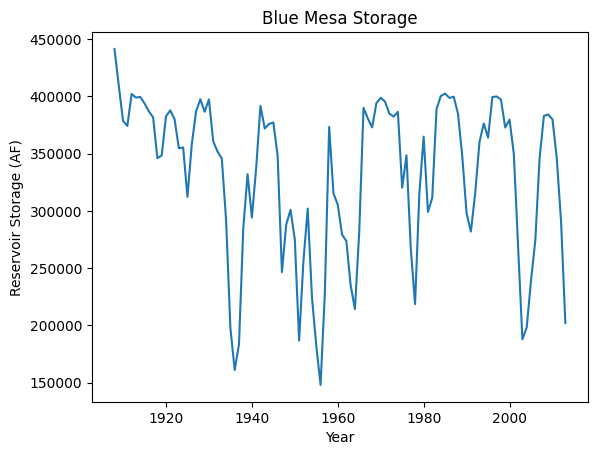

In [7]:
fig, ax = plt.subplots()

plt.plot(df['Year'], df['Init. Storage'])

plt.title("Blue Mesa Storage")
plt.xlabel("Year")
plt.ylabel("Reservoir Storage (AF)")


### Step 2: Modify StateMod Input Files for Exploratory Analyses- Evaporation Function Example

Now that we've run StateMod in baseline mode for the Gunnison, the next step is to run it in exploratory analysis mode. To do this, we need to create some plausible futures and adjust the input files for StateMod. In this step, we'll demonstrate Option 1 for `statemodify` adjustments using the `gm2015.eva` file as an example. Here we apply additives rather than multipliers. As done in Hadjimichael et al. (2020), we sample the change of evaporation between -15.24 and 30.46 cm/month (-0.5 to + 1 ft). The .eva file stores information for select larger reservoirs across all West Slope basins. We choose the ID that corresponds to Blue Mesa (10011). We create 2 alternative states of the world and store them in the `input_files` directory. 

In [8]:
# a dictionary to describe what you want to modify and the bounds for the LHS
setup_dict = {
    "ids": ['10011'],
    "bounds": [-0.5, 1.0]
}

# create a directory to store the new files in if it does not exist
output_directory = os.path.join(data_dir, "input_files")
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# scenario name
scenario = "1"

# the number of samples you wish to generate
n_samples = 2

# seed value for reproducibility if so desired
seed_value = 1

# number of rows to skip in file after comment
skip_rows = 1

# name of field to query
query_field = "id"

# number of jobs to launch in parallel; -1 is all but 1 processor used
n_jobs = -1

# basin to process
basin_name = "Gunnison"

# generate a batch of files using generated LHS
stm.modify_eva(modify_dict=setup_dict,
               query_field=query_field,
               output_dir=output_directory,
               scenario=scenario,
               basin_name=basin_name,
               sampling_method="LHS",
               n_samples=n_samples,
               skip_rows=skip_rows,
               n_jobs=n_jobs,
               seed_value=seed_value,
               template_file=None,
               factor_method="add",
               data_specification_file=None,
               min_bound_value=-0.5,
               max_bound_value=1.0,
               save_sample=True)


If we print our two samples below, we see that we've created a state of the world that has reduced evaporation (subtracting 0.18 ft) and one with increased evaporation (adding 0.79 ft). These samples will be termed SOW 1 and SOW 2 respectively.

In [9]:
# path to the numpy file containing the samples
eva_samples_file = os.path.join(output_directory, "eva_2-samples_scenario-1.npy")

# load samples 
sample_array = np.load(eva_samples_file)

sample_array


array([[-0.1872335 ],
       [ 0.79024337]])

### Step 3: Read in the New Input Files and Run StateMod : Evaporation Example

Now that we have created the input files, the next step is to run StateMod with the new input files. We create a template .rsp file (`gm2015B_template_eva.rsp`) and swap in the path to the alternative `.eva` files that are created. Then we run StateMod for the two scenarios and extract the reservoir levels for Blue Mesa.

In [10]:
# set realization and sample
realization = 1
sample = np.arange(0, 2, 1)

# read RSP template
with open(eva_template_file) as template_obj:
    
    # read in file
    template_rsp = Template(template_obj.read())

    for i in sample:
        
        # create scenario name
        scenario = f"S{i}_{realization}"
        
        # dictionary holding search keys and replacement values to update the template file
        d = {"EVA": f"../../input_files/gm2015B_{scenario}.eva"}
        
        # update the template
        new_rsp = template_rsp.safe_substitute(d)
        
        # construct simulated scenario directory
        simulated_scenario_dir = os.path.join(scenarios_dir, scenario)
        if not os.path.exists(simulated_scenario_dir):
            os.makedirs(simulated_scenario_dir)
            
        # target rsp file
        rsp_file = os.path.join(simulated_scenario_dir, f"gm2015B_{scenario}.rsp")
        
        # write updated rsp file
        with open(rsp_file, "w") as f1:
            f1.write(new_rsp)
        
        # construct simulated basin path
        simulated_basin_path = os.path.join(simulated_scenario_dir, f"gm2015B_{scenario}")

        # run StateMod
        print(f"Running: {scenario}")
        os.chdir(simulated_scenario_dir)

        subprocess.call([statemod_exe, simulated_basin_path, "-simulate"])


Running: S0_1
 Startup log file for messages to this point: /home/8f04c5969ed54204a64388872dd1b557/data/gm2015_StateMod_modified/gm2015_StateMod_modified/StateMod/scenarios/S0_1/gm2015B_S0_1.rsp                                                                                                                          
   Closing startup log file: statem.log
   Opening dataset log file: /home/8f04c5969ed54204a64388872dd1b557/data/gm2015_StateMod_modified/gm2015_StateMod_modified/StateMod/scenarios/S0_1/gm2015B_S0_1.log                                                                                                                          
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version:     17.0.3          
        Last revision date: 2021/09/12

________________________________________________________________________
  
  Subroutine Execut
  Subro

### Step 4: Visualize Reservoir Levels in New SOWs

Using `extract_xre_data()`, we can then extract the reservoir levels at Blue Mesa in the two new SOWs.

In [12]:
# SOW 1
output_dir= os.path.join(scenarios_dir, "S0_1")

# path the the xre file
xre_file = os.path.join(output_dir, "gm2015B_S0_1.xre") 

# structure ID for reservoir of interest
structure_ID = '6203532'  

# name of the reservoir
structure_name = 'Blue_Mesa' 

# extract the target info into a Pandas data frame
df = stm.extract_xre_data(structure_name=structure_name,
                          structure_id=structure_ID,
                          input_file=xre_file,
                          basin_name=None,
                          output_directory=output_dir,
                          write_csv=True,
                          write_parquet=None
)

# SOW 2
output_dir= os.path.join(scenarios_dir, "S1_1")

# path the the xre file
xre_file = os.path.join(output_dir, "gm2015B_S1_1.xre") 


# extract the target info into a Pandas data frame
df = stm.extract_xre_data(structure_name=structure_name,
                          structure_id=structure_ID,
                          input_file=xre_file,
                          basin_name=None,
                          output_directory=output_dir,
                          write_csv=True,
                          write_parquet=None
)


Finally, we can plot reservoir storage through time in our baseline world and alternative states of the world.


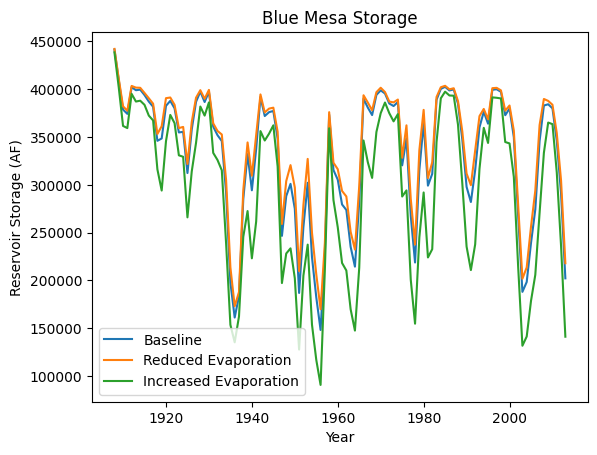

In [13]:
# historic reservoir directory
historic_res_dir = os.path.join(data_dir, "historic_reservoir_levels")
blue_mesa_file = os.path.join(historic_res_dir, "Blue_Mesa_xre_data.csv")

# Import baseline dataframe 
baseline = pd.read_csv(blue_mesa_file, index_col=False, usecols=['Year','Init. Storage']) 
baseline = baseline.groupby('Year').mean().reset_index()

# Import SOW1
s0_1_file = os.path.join(scenarios_dir, "S0_1", "Blue_Mesa_xre_data.csv")
SOW1 = pd.read_csv(s0_1_file, index_col=False, usecols=['Year','Init. Storage']) 
SOW1 = SOW1.groupby('Year').mean().reset_index()
 
# Import SOW2
s1_1_file = os.path.join(scenarios_dir, "S1_1", "Blue_Mesa_xre_data.csv")
SOW2 = pd.read_csv(s1_1_file, index_col=False, usecols=['Year','Init. Storage']) 
SOW2 = SOW2.groupby('Year').mean().reset_index()
 
# Plot reservoir levels 
fig, ax = plt.subplots()

plt.plot(baseline['Year'], baseline['Init. Storage'],label='Baseline')
plt.plot(SOW1['Year'], SOW1['Init. Storage'],label='Reduced Evaporation')
plt.plot(SOW2['Year'], SOW2['Init. Storage'],label='Increased Evaporation')

plt.title("Blue Mesa Storage")
plt.xlabel("Year")
plt.ylabel("Reservoir Storage (AF)")

plt.legend()


We see that in SOW 1 (which corresponds to reduced evaporation), the Blue Mesa storage is slightly higher than baseline. However, in SOW 2, which corresponds to increased evaporation, we see that the reservoir storage has reduced considerably.

We now encourage the user to explore how the changes in reservoir storage impacts user shortages in Quickstarter Notebook #3. 

### References

Hadjimichael, A., Quinn, J., Wilson, E., Reed, P., Basdekas, L., Yates, D., & Garrison, M. (2020). Defining robustness, vulnerabilities, and consequential scenarios for diverse stakeholder interests in institutionally complex river basins. Earth's Future, 8(7), e2020EF001503.